# X3 and X6 partitioning experiments
## With additional data generation:
+ additional data will be using mean with extremes removed (not min and max as in part 1)<br>
+ additional data will be used for training the models, while supplied training data will be used for evaluatig (testing) of the models.

## With segmentation of the datasets along X3 and X6:
+ start with big segments and part off the areas uniform, build model for area.<br>
+ repeat until outliers are under control.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import string
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
#from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score
#from sklearn.kernel_ridge import KernelRidge
#from sklearn import svm
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.neural_network import MLPRegressor
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import Matern

/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Load Data Sets

In [15]:
df_train = pd.read_csv('../data/train.csv', index_col = 'ID').fillna(0)
df_train = df_train[df_train['y'] < 200] # drop one outlier data
df_test = pd.read_csv('../data/test.csv', index_col = 'ID').fillna(0)
li_del_columns = []

## 2. Construct additional features and change letter categorical to binary

In [16]:
def my_dummies(c, df1, df2):
    l = len(df1)
    df = pd.concat([df1, df2], axis = 0)
    df_temp = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df_temp, df], axis = 1)
    df = df.drop(c, axis = 1)
    df1 = df[ : l].copy()
    df2 = df[l : ].copy()
    return df1, df2

In [17]:
li_columnNames = [e for e in list(df_train.columns.values) if e not in {'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'}]
li_categorical = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
list_value = list(string.lowercase) + list('a' + x for x in list(string.lowercase)) + ['ba', 'bb', 'bc']

df_train_eng = df_train.copy()
df_test_eng = df_test.copy()
df_train_eng['qty_options'] = df_train_eng[li_columnNames].sum(axis=1)
df_test_eng['qty_options'] = df_test_eng[li_columnNames].sum(axis=1)

for c in li_categorical:
    df_train_eng, df_test_eng = my_dummies(c, df_train_eng, df_test_eng)


## 3. some data clensing / Identifying data for possible clensing
### Identify duplicate columns

In [18]:
all_data = pd.concat((df_train_eng, df_test_eng))

# remove duplicated columns
c = all_data.columns
print('\n Number of columns before cleaning: %d' % len(c))
li_duplicates = []
for i in range(len(c)-1):
    v = all_data[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,all_data[c[j]].values):
            li_duplicates.append(c[j])
            print(' Column %s is identical to %s. Removing %s' % (str(c[i]), str(c[j]), str(c[j])))
li_duplicates = list(set(li_duplicates))
print '\n Number of identified duplicates marked: %s' % len(li_duplicates)


 Number of columns before cleaning: 581
 Column X2_a is identical to X32. Removing X32
 Column X2_ac is identical to X125. Removing X125
 Column X2_ac is identical to X227. Removing X227
 Column X2_ad is identical to X107. Removing X107
 Column X2_ag is identical to X30. Removing X30
 Column X2_ai is identical to X215. Removing X215
 Column X2_am is identical to X260. Removing X260
 Column X2_ap is identical to X16. Removing X16
 Column X2_aq is identical to X211. Removing X211
 Column X2_as is identical to X251. Removing X251
 Column X2_at is identical to X184. Removing X184
 Column X2_at is identical to X262. Removing X262
 Column X2_au is identical to X59. Removing X59
 Column X2_aw is identical to X213. Removing X213
 Column X2_aw is identical to X67. Removing X67
 Column X2_b is identical to X26. Removing X26
 Column X2_d is identical to X97. Removing X97
 Column X2_f is identical to X23. Removing X23
 Column X2_g is identical to X112. Removing X112
 Column X2_g is identical to X

### Dropping duplicate columns
(yes there are columns duplicate and complimentary, so need to do it twice)

In [19]:
print 'Number columns before cleaning: ', df_train_eng.shape[1],
l = len(df_train_eng)
df = pd.concat([df_train_eng, df_test_eng], axis = 0)
for c in li_duplicates:
    df.drop(c, axis=1, inplace = True)

df_train_eng = df[ : l].copy()
df_test_eng = df[l : ].copy()
print 'and after cleaning: ', df_train_eng.shape[1]

Number columns before cleaning:  581 and after cleaning:  519


### Identify complementary columns

In [20]:
list_index = [e for e in list(df_train_eng.columns.values) if e not in {'y_actual', 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'}]
all_data = pd.concat((df_train_eng[list_index], df_test_eng[list_index]))
value_compliment = {0: 1, 1: 0}

# remove complimentary columns
c = all_data.columns
print('\n Number of columns before cleaning: %d' % len(c))
li_compliments = []
for i in range(len(c)-1):
    v = all_data[c[i]].replace(value_compliment).values
    for j in range(i+1,len(c)):
        if np.array_equal(v,all_data[c[j]].values):
            li_compliments.append(c[j])
            print(' Column %s is complimentary to %s. Removing %s' % (str(c[i]), str(c[j]), str(c[j])))
li_compliments = list(set(li_compliments))
print '\n Number of identified complements marked: %s' % len(li_compliments)


 Number of columns before cleaning: 518
 Column X128 is complimentary to X130. Removing X130
 Column X156 is complimentary to X157. Removing X157
 Column X204 is complimentary to X205. Removing X205
 Column X232 is complimentary to X263. Removing X263

 Number of identified complements marked: 4


### Droping complementary columns

In [21]:
print 'Number columns before cleaning: ', df_train_eng.shape[1],
l = len(df_train_eng)
df = pd.concat([df_train_eng, df_test_eng], axis = 0)
for c in li_compliments:
    df.drop(c, axis=1, inplace = True)

df_train_eng = df[ : l].copy()
df_test_eng = df[l : ].copy()
print 'and after cleaning: ', df_train_eng.shape[1]

Number columns before cleaning:  519 and after cleaning:  515


### let's see if we have same datarows (other then y and y_actual) in train data
<font color=red>SKIP TO "GENERATING MORE DATA" IF LOADING PRE-PROCESSED DATASET. THIS STEP TAKES TIME!</font>

<i>mean</i> is calcualted out of all identical datarows.<br>
<i>mean minus extremes</i> is calculated if four or more datasets are identical by removing the lowest and highest value. <br>
<i>mean narrowing</i> is calculated if four or more datasets are identical by removing values that are more than 5% away from mean

In [22]:
li_columns = [e for e in list(df_train_eng.columns.values) if e not in {'y_actual', 'y'}]
df = df_train_eng[li_columns]
li_seen_duplicates = []
li_duplicates = []
print 'start finding...'
#for i in range(235):
for i in range(len(df)):
    if i not in li_seen_duplicates:
        set_pairs = {}
        v = df.iloc[i, :].values
        for j in range(i+1,len(df)):
            if np.array_equal(v,df.iloc[j, :].values):
                if i not in li_seen_duplicates: li_seen_duplicates.append(i)
                li_seen_duplicates.append(j)
                if i not in set_pairs: set_pairs[i] = df_train_eng.ix[df_train_eng.index.tolist()[i],'y']
                set_pairs[j] = df_train_eng.ix[df_train_eng.index.tolist()[j],'y']
        if set_pairs: li_duplicates.append(set_pairs)
    if ((i > 0) & (i % 100 == 0)): print '.',
for i in range(len(li_duplicates)):
    values = li_duplicates[i].values()
    val_narrow = []
    mean = sum(values) / len(values)
    deviate = 0.08
    print '\n Row IDs ', list(li_duplicates[i].keys()), ' mean: ', mean, ' with values: ', values,
    if len(values) >= 4:
        print ', mean minus extremes: ', (sum(values) - min(values) - max(values)) / (len(values) - 2),
    if len(values) >= 4:
        for v in values:
            if mean*(1-deviate) <= v <= mean*(1+deviate):
                val_narrow.append(v)
        print ', mean narrowing: ', sum(val_narrow) / len(val_narrow),

start finding...


/home/kaggler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 Row IDs  [16, 130, 51, 13, 79]  mean:  96.788  with values:  [106.09999999999999, 96.879999999999995, 93.810000000000002, 94.120000000000005, 93.030000000000001] , mean minus extremes:  94.9366666667 , mean narrowing:  94.46 
 Row IDs  [18, 93]  mean:  94.36  with values:  [89.810000000000002, 98.909999999999997] 
 Row IDs  [32, 98, 106, 45, 23, 90, 123, 29, 95]  mean:  115.602222222  with values:  [106.87, 127.66, 106.31, 110.52, 120.77, 110.98, 113.69, 128.19, 115.43000000000001] , mean minus extremes:  115.131428571 , mean narrowing:  113.043333333 
 Row IDs  [38, 30]  mean:  77.505  with values:  [79.0, 76.010000000000005] 
 Row IDs  [37, 85]  mean:  113.84  with values:  [117.31, 110.37] 
 Row IDs  [72, 58, 110]  mean:  101.196666667  with values:  [118.53, 95.569999999999993, 89.489999999999995] 
 Row IDs  [64, 77]  mean:  110.455  with values:  [109.76000000000001, 111.15000000000001] 
 Row IDs

Next, let's make a copy of the trainingdata and set the values for all identical row sets to the mean or mean narrow if more than 3 values.

In [24]:
df_train_cp = df_train_eng.copy()

In [25]:
for i in range(len(li_duplicates)):
    values = li_duplicates[i].values()
    mean = sum(values) / len(values)
    if len(values) > 3:
        for v in values:
            if mean*(1-deviate) <= v <= mean*(1+deviate):
                val_narrow.append(v)
        mean = sum(val_narrow) / len(val_narrow)
    for j in list(li_duplicates[i].keys()):
        df_train_cp.set_value(j ,'y', mean)

Write out the dataframe as is to load in this state if required.

In [26]:
df_train_cp.to_csv(path_or_buf='../data/train_cp.csv', index_label='ID', header=True)

In [36]:
df_train_eng.to_csv(path_or_buf='../data/train_eng.19.csv', index_label='ID', header=True)

### generating some more training data
the amount of data considering the binary features is not much, hence let's produce some more.
I figure I'll be adding 10 rows for each pre-existing row: I'll be adding / subtracting a small percentage (probably 1% times number of rows away from start) from the goal y value. The average of the rowset stays the same; the variance is smaller to what I have seen in the dataset earlier (see checking for identical rows and the y values). This should afford me sufficient data to get good model fitting.

In [29]:
df_train_cp = pd.read_csv('../data/train_cp.csv', index_col = 'ID')

In [30]:
df_add = pd.DataFrame.from_items([(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df_train_cp.iteritems()])
df_add = pd.DataFrame(data = None, columns=df_train_cp.columns)
y_index = df_train_cp.columns.get_loc('y')
add_vals = 10
add_factor = 0.01
add_range = range(-(add_vals/2), 0) + range(1, (add_vals/2) + 1)
for i in range(len(df_train_cp)):
    values = list(df_train_cp.iloc[i,:])
    li_add = []
    for j in add_range:
        li_add.append(values[:])
        li_add[len(li_add)-1][y_index] = values[y_index]*(1 + j*add_factor)
    df_add = df_add.append(pd.DataFrame(li_add, columns=df_train_cp.columns))

In [31]:
df_train_cp = pd.concat([df_train_cp, df_add], axis = 0)
df_train_cp.shape

(49324, 515)

In [32]:
df_train_cp['y_actual'] = df_train_cp['y'] * df_train_cp['qty_options'] # Remember that one from further up? Now you see why.

In [37]:
df_train_eng['y_actual'] = df_train_eng['y'] * df_train_eng['qty_options']

In [33]:
df_train_cp.to_csv(path_or_buf='../data/train_cp_XL.csv', index_label='ID', header=True)

In [ ]:
df_train_cp = pd.read_csv('../data/train_cp_XL.csv', index_col = 'ID')

In [34]:
for i in ['X3_a', 'X3_b', 'X3_c', 'X3_d', 'X3_e', 'X3_f', 'X3_g']:
    print i, ' mean y:',
    print df_train_cp[(df_train_cp[i] == 1)]['y'].mean(), ' y_actual:',
    print df_train_cp[(df_train_cp[i] == 1)]['y_actual'].mean(), 'sigma:',
    print df_train_cp[(df_train_cp[i] == 1)]['y'].std(), ' Datasets:',
    print df_train_cp[(df_train_cp[i] == 1)].shape[0]

X3_a  mean y: 102.54389213  y_actual: 6252.06563224 sigma: 12.2050103031  Datasets: 4840
X3_b  mean y: 100.278157895  y_actual: 5606.79377193 sigma: 10.7172358958  Datasets: 627
X3_c  mean y: 101.991260849  y_actual: 6119.74591832 sigma: 12.7935021007  Datasets: 21362
X3_d  mean y: 104.747732493  y_actual: 5909.57985247 sigma: 10.2268751422  Datasets: 3190
X3_e  mean y: 100.079326692  y_actual: 5756.25331581 sigma: 11.0200814603  Datasets: 1793
X3_f  mean y: 96.7962847608  y_actual: 5230.18854792 sigma: 13.3507639374  Datasets: 11825
X3_g  mean y: 100.807721005  y_actual: 5902.35643765 sigma: 10.6391764704  Datasets: 2651


In [38]:
for i in ['X3_a', 'X3_b', 'X3_c', 'X3_d', 'X3_e', 'X3_f', 'X3_g']:
    print i, ' mean y:',
    print df_train_eng[(df_train_eng[i] == 1)]['y'].mean(), ' y_actual:',
    print df_train_eng[(df_train_eng[i] == 1)]['y_actual'].mean(), 'sigma:',
    print df_train_eng[(df_train_eng[i] == 1)]['y'].std(), ' Datasets:',
    print df_train_eng[(df_train_eng[i] == 1)].shape[0]

X3_a  mean y: 102.507477273  y_actual: 6251.17375 sigma: 11.7209104558  Datasets: 440
X3_b  mean y: 100.239649123  y_actual: 5609.35368421 sigma: 10.2040648352  Datasets: 57
X3_c  mean y: 101.959268795  y_actual: 6117.26341401 sigma: 12.4146420334  Datasets: 1942
X3_d  mean y: 105.114413793  y_actual: 5930.47831034 sigma: 9.87888653322  Datasets: 290
X3_e  mean y: 100.033190184  y_actual: 5751.59521472 sigma: 10.4960935535  Datasets: 163
X3_f  mean y: 96.4075255814  y_actual: 5209.7048186 sigma: 13.0698420549  Datasets: 1075
X3_g  mean y: 100.428672199  y_actual: 5882.50087137 sigma: 10.1089545237  Datasets: 241


I don't like these sigmas. It's around 10% of the mean value. Let's see if I can narrow them:

In [41]:
for i in ['X3_a', 'X3_b', 'X3_c', 'X3_d', 'X3_e', 'X3_f', 'X3_g']:
    for j in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
        print i, ', ', j, ' mean y:',
        print df_train_cp[((df_train_cp[i] == 1) & (df_train_cp[j] == 1))]['y'].mean(), ' y_actual:',
        print df_train_cp[((df_train_cp[i] == 1) & (df_train_cp[j] == 1))]['y_actual'].mean(), 'sigma:',
        print df_train_cp[((df_train_cp[i] == 1) & (df_train_cp[j] == 1))]['y'].std(), ' Datasets:',
        print df_train_cp[((df_train_cp[i] == 1) & (df_train_cp[j] == 1))].shape[0]

X3_a ,  X6_a  mean y: 101.127894737  y_actual: 6231.44157895 sigma: 11.0387001828  Datasets: 209
X3_a ,  X6_b  mean y: 97.6833333333  y_actual: 6366.86166667 sigma: 10.5886326594  Datasets: 66
X3_a ,  X6_c  mean y: 107.4675  y_actual: 6945.105 sigma: 6.22276574101  Datasets: 44
X3_a ,  X6_d  mean y: 103.581089744  y_actual: 6398.15987179 sigma: 10.0459398888  Datasets: 572
X3_a ,  X6_e  mean y: 111.33  y_actual: 6679.8 sigma: 3.6923983791  Datasets: 11
X3_a ,  X6_f  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_a ,  X6_g  mean y: 102.517154652  y_actual: 6323.57515799 sigma: 13.3579351365  Datasets: 1034
X3_a ,  X6_h  mean y: 104.7605  y_actual: 6519.202 sigma: 13.2600080842  Datasets: 220
X3_a ,  X6_i  mean y: 99.0510648148  y_actual: 6012.34263889 sigma: 9.53710720182  Datasets: 396
X3_a ,  X6_j  mean y: 103.922534435  y_actual: 6321.51944904 sigma: 13.6791998095  Datasets: 1331
X3_a ,  X6_k  mean y: 104.766666667  y_actual: 6265.605 sigma: 8.38765239189  Datasets: 66
X3_a , 

In [74]:
df_interest = df_train_eng.copy()
for i in ['X0_az']:
    print i, ' mean y:',
    print df_interest[(df_interest[i] == 1)]['y'].mean(), ' y_actual:',
    print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), 'sigma:',
    print df_interest[(df_interest[i] == 1)]['y'].std(), ' Datasets:',
    print df_interest[(df_interest[i] == 1)].shape[0]
    df_interest = df_interest[(df_interest[i] == 0)]
heat_map = []
for i in ['X3_a', 'X3_b', 'X3_c', 'X3_d', 'X3_e', 'X3_f', 'X3_g']:
    heat_map_sub = []
    for j in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
        print i, ', ', j, ' mean y:',
        print df_interest[((df_interest[i] == 1) & (df_interest[j] == 1))]['y'].mean(), ' y_actual:',
        print df_interest[((df_interest[i] == 1) & (df_interest[j] == 1))]['y_actual'].mean(), 'sigma:',
        print df_interest[((df_interest[i] == 1) & (df_interest[j] == 1))]['y'].std(), ' Datasets:',
        print df_interest[((df_interest[i] == 1) & (df_interest[j] == 1))].shape[0]
        heat_map_sub.append(df_interest[((df_interest[i] == 1) & (df_interest[j] == 1))]['y'].std())
    heat_map.append(heat_map_sub)

X0_az  mean y: 78.0255428571  y_actual: 4526.98874286 sigma: 4.67708299125  Datasets: 175
X3_a ,  X6_a  mean y: 101.127894737  y_actual: 6231.44157895 sigma: 10.8210435823  Datasets: 19
X3_a ,  X6_b  mean y: 97.6833333333  y_actual: 6366.86166667 sigma: 10.9969571549  Datasets: 6
X3_a ,  X6_c  mean y: 107.4675  y_actual: 6945.105 sigma: 5.91801979832  Datasets: 4
X3_a ,  X6_d  mean y: 104.354038462  y_actual: 6442.91807692 sigma: 8.70593064922  Datasets: 52
X3_a ,  X6_e  mean y: 111.33  y_actual: 6679.8 sigma: nan  Datasets: 1
X3_a ,  X6_f  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_a ,  X6_g  mean y: 102.561382979  y_actual: 6328.2212766 sigma: 13.0586180172  Datasets: 94
X3_a ,  X6_h  mean y: 104.7605  y_actual: 6519.202 sigma: 13.1345244039  Datasets: 20
X3_a ,  X6_i  mean y: 98.6697222222  y_actual: 5992.89916667 sigma: 8.70675681332  Datasets: 36
X3_a ,  X6_j  mean y: 103.861735537  y_actual: 6317.74991736 sigma: 13.3104729241  Datasets: 121
X3_a ,  X6_k  mean y: 104.76

In [ ]:
X3_a ,  X6_a  mean y: 101.127894737  y_actual: 6231.44157895 sigma: 10.8210435823  Datasets: 19
X3_a ,  X6_b  mean y: 97.6833333333  y_actual: 6366.86166667 sigma: 10.9969571549  Datasets: 6
X3_a ,  X6_c  mean y: 107.4675  y_actual: 6945.105 sigma: 5.91801979832  Datasets: 4
X3_a ,  X6_d  mean y: 104.354038462  y_actual: 6442.91807692 sigma: 8.70593064922  Datasets: 52
X3_a ,  X6_e  mean y: 111.33  y_actual: 6679.8 sigma: nan  Datasets: 1
X3_a ,  X6_f  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_a ,  X6_g  mean y: 102.561382979  y_actual: 6328.2212766 sigma: 13.0586180172  Datasets: 94
X3_a ,  X6_h  mean y: 104.7605  y_actual: 6519.202 sigma: 13.1345244039  Datasets: 20
X3_a ,  X6_i  mean y: 98.6697222222  y_actual: 5992.89916667 sigma: 8.70675681332  Datasets: 36
X3_a ,  X6_j  mean y: 103.861735537  y_actual: 6317.74991736 sigma: 13.3104729241  Datasets: 121
X3_a ,  X6_k  mean y: 104.766666667  y_actual: 6265.605 sigma: 8.36079820751  Datasets: 6
X3_a ,  X6_l  mean y: 100.545555556  y_actual: 5943.25123457 sigma: 10.3085172309  Datasets: 81
X3_b ,  X6_a  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_b ,  X6_b  mean y: 112.22  y_actual: 6957.64 sigma: nan  Datasets: 1
X3_b ,  X6_c  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_b ,  X6_d  mean y: 103.584  y_actual: 6737.034 sigma: 12.5342622439  Datasets: 5
X3_b ,  X6_e  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_b ,  X6_f  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_b ,  X6_g  mean y: 93.5288888889  y_actual: 4560.31777778 sigma: 6.60246735421  Datasets: 18
X3_b ,  X6_h  mean y: 103.75  y_actual: 6937.05666667 sigma: 9.82871303885  Datasets: 3
X3_b ,  X6_i  mean y: 112.848  y_actual: 6959.096 sigma: 5.56943174839  Datasets: 5
X3_b ,  X6_j  mean y: 101.846  y_actual: 5710.6755 sigma: 7.79323620368  Datasets: 20
X3_b ,  X6_k  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_b ,  X6_l  mean y: 97.518  y_actual: 5436.894 sigma: 16.2758124221  Datasets: 5
X3_c ,  X6_a  mean y: 99.5435869565  y_actual: 6029.09369565 sigma: 11.9874419254  Datasets: 92
X3_c ,  X6_b  mean y: 101.644666667  y_actual: 6623.12533333 sigma: 15.5263885354  Datasets: 15
X3_c ,  X6_c  mean y: 104.317272727  y_actual: 6314.19636364 sigma: 15.0056126584  Datasets: 22
X3_c ,  X6_d  mean y: 102.240369128  y_actual: 6274.02932886 sigma: 11.5741075911  Datasets: 298
X3_c ,  X6_e  mean y: 108.214  y_actual: 6791.066 sigma: 14.5759675494  Datasets: 5
X3_c ,  X6_f  mean y: 90.35  y_actual: 5692.05 sigma: nan  Datasets: 1
X3_c ,  X6_g  mean y: 101.32732334  y_actual: 6048.07314775 sigma: 12.147508598  Datasets: 467
X3_c ,  X6_h  mean y: 104.11980198  y_actual: 6350.46574257 sigma: 13.1213741643  Datasets: 101
X3_c ,  X6_i  mean y: 102.124010989  y_actual: 6160.36972527 sigma: 12.7176355068  Datasets: 182
X3_c ,  X6_j  mean y: 102.371549815  y_actual: 6144.51370849 sigma: 13.2447569718  Datasets: 542
X3_c ,  X6_k  mean y: 103.909411765  y_actual: 6748.74058824 sigma: 10.0025468448  Datasets: 17
X3_c ,  X6_l  mean y: 101.2691  y_actual: 5726.9605 sigma: 10.9009461205  Datasets: 200
X3_d ,  X6_a  mean y: 106.7  y_actual: 5964.40714286 sigma: 12.4171131911  Datasets: 7
X3_d ,  X6_b  mean y: 108.9  y_actual: 8167.5 sigma: nan  Datasets: 1
X3_d ,  X6_c  mean y: 97.91  y_actual: 5855.725 sigma: 9.13581961293  Datasets: 2
X3_d ,  X6_d  mean y: 107.036226415  y_actual: 6251.40735849 sigma: 9.93447188531  Datasets: 53
X3_d ,  X6_e  mean y: 109.14  y_actual: 6334.36 sigma: 1.49906637612  Datasets: 2
X3_d ,  X6_f  mean y: 96.465  y_actual: 6161.86166667 sigma: 10.0077345089  Datasets: 6
X3_d ,  X6_g  mean y: 106.037936508  y_actual: 6050.73396825 sigma: 10.1715844166  Datasets: 63
X3_d ,  X6_h  mean y: 105.753636364  y_actual: 5621.59090909 sigma: 10.1895457843  Datasets: 22
X3_d ,  X6_i  mean y: 106.544722222  y_actual: 5796.74166667 sigma: 8.83321183654  Datasets: 36
X3_d ,  X6_j  mean y: 104.224705882  y_actual: 5819.59588235 sigma: 9.3044611149  Datasets: 85
X3_d ,  X6_k  mean y: 109.6  y_actual: 6116.61 sigma: 4.15778787338  Datasets: 2
X3_d ,  X6_l  mean y: 94.6081818182  y_actual: 5162.87454545 sigma: 8.21226256056  Datasets: 11
X3_e ,  X6_a  mean y: 99.3376923077  y_actual: 5698.48307692 sigma: 7.79375193541  Datasets: 13
X3_e ,  X6_b  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_e ,  X6_c  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_e ,  X6_d  mean y: 100.555  y_actual: 5621.6735 sigma: 11.7118961115  Datasets: 20
X3_e ,  X6_e  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_e ,  X6_f  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_e ,  X6_g  mean y: 100.94925  y_actual: 6028.66 sigma: 9.66136540425  Datasets: 40
X3_e ,  X6_h  mean y: 98.5  y_actual: 5285.53333333 sigma: 10.4199117079  Datasets: 6
X3_e ,  X6_i  mean y: 98.7252173913  y_actual: 5664.35217391 sigma: 11.1308702059  Datasets: 23
X3_e ,  X6_j  mean y: 99.7782926829  y_actual: 5793.61390244 sigma: 10.6592260278  Datasets: 41
X3_e ,  X6_k  mean y: 103.42  y_actual: 6425.02 sigma: 9.1782460198  Datasets: 2
X3_e ,  X6_l  mean y: 100.306666667  y_actual: 5414.90888889 sigma: 12.9443696595  Datasets: 18
X3_f ,  X6_a  mean y: 91.5311290323  y_actual: 5029.25112903 sigma: 12.9408275136  Datasets: 62
X3_f ,  X6_b  mean y: 85.9125  y_actual: 4570.3 sigma: 4.48134931317  Datasets: 4
X3_f ,  X6_c  mean y: 103.53375  y_actual: 5866.24375 sigma: 30.271611377  Datasets: 8
X3_f ,  X6_d  mean y: 96.9497484277  y_actual: 5307.8145283 sigma: 10.613913841  Datasets: 159
X3_f ,  X6_e  mean y: 119.52  y_actual: 6941.665 sigma: 6.18011326757  Datasets: 2
X3_f ,  X6_f  mean y: 94.3961538462  y_actual: 5851.60307692 sigma: 6.26980135047  Datasets: 13
X3_f ,  X6_g  mean y: 96.4935333333  y_actual: 5311.16586667 sigma: 13.8795222531  Datasets: 300
X3_f ,  X6_h  mean y: 98.7533333333  y_actual: 4951.77 sigma: 14.2572218441  Datasets: 30
X3_f ,  X6_i  mean y: 100.078011696  y_actual: 5676.95678363 sigma: 12.0757170348  Datasets: 171
X3_f ,  X6_j  mean y: 95.1709659091  y_actual: 4978.23869318 sigma: 13.2376768648  Datasets: 176
X3_f ,  X6_k  mean y: 99.5345454545  y_actual: 5611.25363636 sigma: 23.8514936067  Datasets: 11
X3_f ,  X6_l  mean y: 93.820647482  y_actual: 4596.79863309 sigma: 10.9529307976  Datasets: 139
X3_g ,  X6_a  mean y: 104.204615385  y_actual: 5970.83538462 sigma: 6.98451097714  Datasets: 13
X3_g ,  X6_b  mean y: 88.46  y_actual: 4865.3 sigma: nan  Datasets: 1
X3_g ,  X6_c  mean y: 96.37  y_actual: 5733.85 sigma: 0.155563491861  Datasets: 2
X3_g ,  X6_d  mean y: 100.803947368  y_actual: 5927.13210526 sigma: 9.32365591776  Datasets: 38
X3_g ,  X6_e  mean y: 103.65  y_actual: 6182.505 sigma: 6.19425540319  Datasets: 2
X3_g ,  X6_f  mean y: nan  y_actual: nan sigma: nan  Datasets: 0
X3_g ,  X6_g  mean y: 103.476333333  y_actual: 6189.832 sigma: 10.6893921704  Datasets: 60
X3_g ,  X6_h  mean y: 99.11  y_actual: 5820.34 sigma: 7.0147640221  Datasets: 8
X3_g ,  X6_i  mean y: 99.318  y_actual: 5993.38228571 sigma: 9.35382331393  Datasets: 35
X3_g ,  X6_j  mean y: 98.5374074074  y_actual: 5679.18259259 sigma: 11.1902987272  Datasets: 54
X3_g ,  X6_k  mean y: 94.648  y_actual: 6285.834 sigma: 10.3376917153  Datasets: 5
X3_g ,  X6_l  mean y: 98.1630434783  y_actual: 5230.72913043 sigma: 9.72399536049  Datasets: 23

In [84]:
for i in ['X3_a', 'X3_b', 'X3_c', 'X3_d', 'X3_e', 'X3_f', 'X3_g']:
    print i, ' mean y:',
    print df_interest[(df_interest[i] == 1)]['y'].mean(), ' y_actual:',
    print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), 'sigma:',
    print df_interest[(df_interest[i] == 1)]['y'].std(), ' Datasets:',
    print df_interest[(df_interest[i] == 1)].shape[0]

X3_a  mean y: 102.507477273  y_actual: 6251.17375 sigma: 11.7209104558  Datasets: 440
X3_b  mean y: 100.239649123  y_actual: 5609.35368421 sigma: 10.2040648352  Datasets: 57
X3_c  mean y: 102.326664924  y_actual: 6133.05582331 sigma: 12.1317291624  Datasets: 1913
X3_d  mean y: 105.114413793  y_actual: 5930.47831034 sigma: 9.87888653322  Datasets: 290
X3_e  mean y: 100.033190184  y_actual: 5751.59521472 sigma: 10.4960935535  Datasets: 163
X3_f  mean y: 99.2869860065  y_actual: 5334.1220775 sigma: 11.5314320241  Datasets: 929
X3_g  mean y: 100.428672199  y_actual: 5882.50087137 sigma: 10.1089545237  Datasets: 241


In [85]:
for i in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
    print i, ' mean y:',
    print df_interest[(df_interest[i] == 1)]['y'].mean(), ' y_actual:',
    print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), 'sigma:',
    print df_interest[(df_interest[i] == 1)]['y'].std(), ' Datasets:',
    print df_interest[(df_interest[i] == 1)].shape[0]

X6_a  mean y: 99.3669473684  y_actual: 5816.55547368 sigma: 11.5052949461  Datasets: 190
X6_b  mean y: 99.9726923077  y_actual: 6410.335 sigma: 13.6207863379  Datasets: 26
X6_c  mean y: 105.2675  y_actual: 6326.59361111 sigma: 16.8607000999  Datasets: 36
X6_d  mean y: 101.770781759  y_actual: 6023.67234528 sigma: 10.8517990047  Datasets: 614
X6_e  mean y: 109.751666667  y_actual: 6629.34916667 sigma: 10.4837882062  Datasets: 12
X6_f  mean y: 94.8145  y_actual: 5936.703 sigma: 7.29473672913  Datasets: 20
X6_g  mean y: 101.363634538  y_actual: 5913.66799197 sigma: 11.9832050915  Datasets: 996
X6_h  mean y: 103.685  y_actual: 6053.96994624 sigma: 12.3269228641  Datasets: 186
X6_i  mean y: 101.753920335  y_actual: 5958.93953878 sigma: 11.3855302509  Datasets: 477
X6_j  mean y: 102.455564598  y_actual: 5960.41574771 sigma: 12.0905343487  Datasets: 983
X6_k  mean y: 104.034  y_actual: 6444.91775 sigma: 12.9387033789  Datasets: 40
X6_l  mean y: 99.7191390728  y_actual: 5433.71364238 sigma: 10

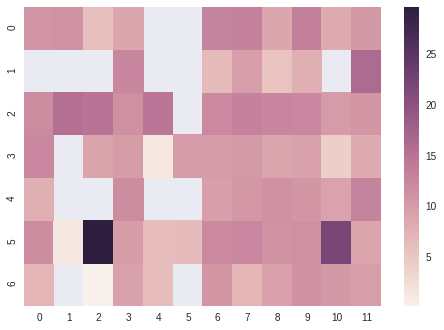

In [75]:
sns.heatmap(heat_map)
plt.show()

The two worst ones: X3_f/X6_c and X3_f/X6_k with 8 and 11 datasets respectively<br>
so let's have a look at these two subsets:

In [81]:
#ids = df_interest[((df_interest['X3_f'] == 1) & (df_interest['X6_c'] == 1))].index.values
ids = df_interest[((df_interest['X3_f'] == 1) & (df_interest['X6_h'] == 1))].index.values

In [83]:
df_train_eng.loc[ids].sort_values('y').sort_values('y').head(100)


,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,...,X91,X93,X94,X95,X96,X98,X99,qty_options,y,y_actual
ID,,,,,,,,,,,,,,,,,,,,,
7963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,55,87.20,4796.00
2461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,43,87.82,3776.26
6356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,43,88.40,3801.20
2169,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,45,89.00,4005.00
1295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,52,89.89,4674.28
3143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,42,92.39,3880.38
169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,52,93.03,4837.56
125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,52,93.81,4878.12
36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,52,94.12,4894.24


In [58]:
df_train[(df_train['X0'] == 'az')]['y'].mean()

78.02554285714281

In [59]:
df_train[(df_train['X0'] == 'az')]['y'].std()

4.677082991252215

In [65]:
df_train[(df_train['X0'] == 'az')][['X3', 'X6', 'y']]

,X3,X6,y
ID,,,
7,c,j,76.26
9,f,l,80.62
13,f,d,78.02
68,f,g,76.01
90,f,g,79.00
147,f,i,84.15
160,f,j,79.03
197,c,j,73.70
385,c,j,79.09


In [62]:
df_train[(df_train['X0'] == 'aa')]['y'].mean()

152.17000000000002

In [63]:
df_train[(df_train['X0'] == 'aa')]['y'].std()

25.0881485964987

In [69]:
df_train[(df_train['X0'] == 'aa')][['X3', 'X6', 'y']]

,X3,X6,y
ID,,,
455,f,h,134.43
681,f,c,169.91


In [68]:
df_train_cp[(df_train_cp['X0_aa'] == 1)].shape

(22, 516)

First candidate: X0_az. low y values, 175 datasets
